In [29]:

import _init_paths
from PIL import Image
import numpy as np
import cv2
import random

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.vqvae import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])


def main(model, nembed=32, rescale=False, decode=True):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    
    visualize_correspondence_quant(enc1, enc2, sample_idx, frame1, frame2, scale=32)
    

In [30]:
## sample frame
import os.path as osp
import glob


# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]
frame2 = cv2.imread(sample['frames_path'][frame_idx+1])[:,:,::-1]
frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))

print('sample frames from {}'.format(sample['frames_path'][0]))

x1 = preprocess_(frame1)
x2 = preprocess_(frame2)

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/4444753edd/00000.jpg


2022-03-04 14:40:11,653 - vcl - INFO - Loading /home/lr/models/ssl/vcl/vfs_pretrain/r18_nc_sgd_cos_100e_r2_1xNx8_k400-db1a4c0d.pth as torchvision


Use load_from_local loader


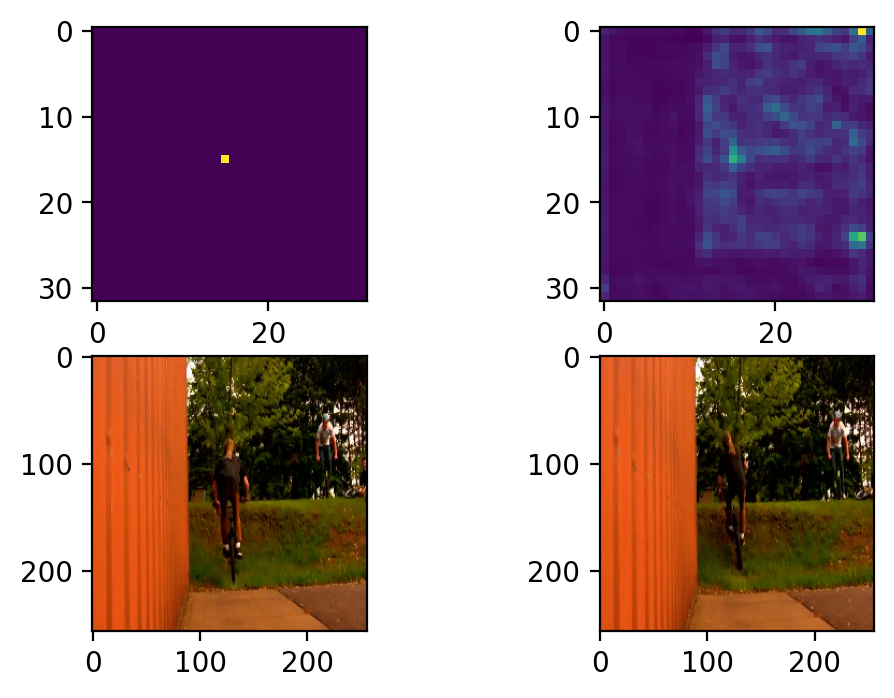

In [31]:
model = VQCL_v5(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, ), pretrained='/home/lr/models/ssl/vcl/vfs_pretrain/r18_nc_sgd_cos_100e_r2_1xNx8_k400-db1a4c0d.pth'),
    sim_siam_head=dict(
        type='SimSiamHead',
        in_channels=128,
        # norm_cfg=dict(type='SyncBN'),
        num_projection_fcs=3,
        projection_mid_channels=128,
        projection_out_channels=128,
        num_predictor_fcs=2,
        predictor_mid_channels=128,
        predictor_out_channels=128,
        with_norm=True,
        spatial_type='avg'),
    loss=dict(type='CosineSimLoss', negative=False),
    embed_dim=128,
    n_embed=2048,
    commitment_cost=1.0
    )
# _ = load_checkpoint(model, '/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d4_nemd2048_contrastive_byol_commit1.0_v2/epoch_3200.pth', map_location='cpu')

model = model.cuda()
model.eval()
main(model, nembed=2048, rescale=True, decode=False)

2022-03-04 14:40:12,250 - vcl - INFO - Loading /home/lr/models/ssl/vcl/vfs_pretrain/r18_nc_sgd_cos_100e_r2_1xNx8_k400-db1a4c0d.pth as torchvision


Use load_from_local loader


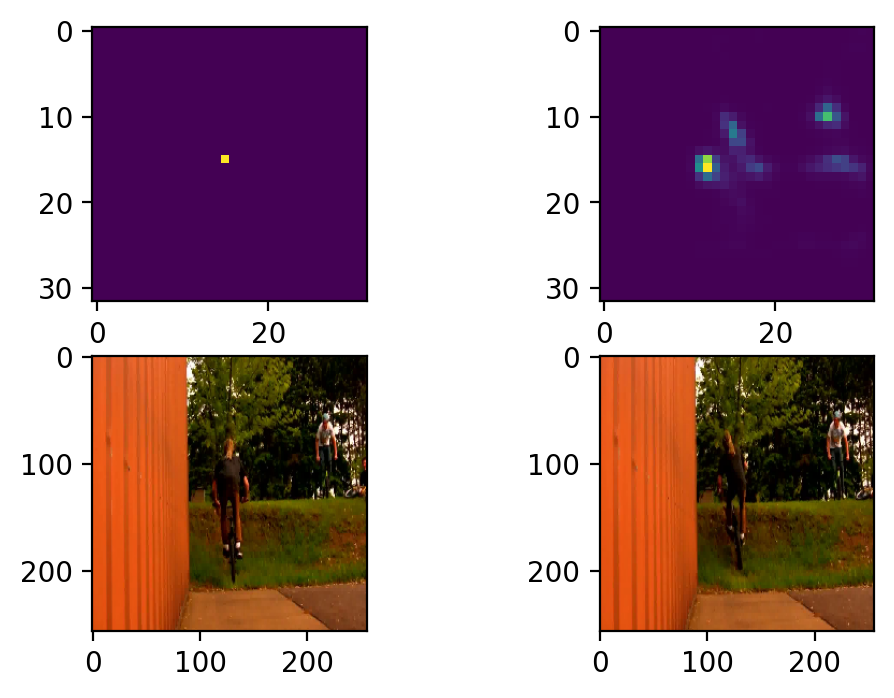

In [32]:
model = VQCL_v5(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, ), pretrained='/home/lr/models/ssl/vcl/vfs_pretrain/r18_nc_sgd_cos_100e_r2_1xNx8_k400-db1a4c0d.pth'),
    sim_siam_head=dict(
        type='SimSiamHead',
        in_channels=128,
        # norm_cfg=dict(type='SyncBN'),
        num_projection_fcs=3,
        projection_mid_channels=128,
        projection_out_channels=128,
        num_predictor_fcs=2,
        predictor_mid_channels=128,
        predictor_out_channels=128,
        with_norm=True,
        spatial_type='avg'),
    loss=dict(type='CosineSimLoss', negative=False),
    embed_dim=128,
    n_embed=2048,
    commitment_cost=1.0
    )
# _ = load_checkpoint(model, '/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d4_nemd2048_contrastive_byol_commit1.0_v2/epoch_3200.pth', map_location='cpu')

model = model.cuda()
model.eval()
main(model, nembed=2048, rescale=True, decode=False)